# Préparation des visualisations

In [1]:
#input
#données métier
filename = 'data_ch_full_join_1pourmil.csv'
#https://public.opendatasoft.com/explore/dataset/code-insee-postaux-geoflar/export/
insee_file = 'code-insee-postaux-geoflar.csv'
#https://www.data.gouv.fr/en/datasets/contours-des-departements-francais-issus-d-openstreetmap/#_
shapefile = 'departements-20140306-100m-shp/departements-20140306-100m.shp'

# logos à afficher que l'on crée soi même
img_urls = {'small' : 'smallgrp.png',
              'medium':'medgrp.png',
              'large':'lrggrp.png'  }

#outputs
#faire tourner si le ficheir n'existe pas
output_interim = 'json_dept.json'

output = 'folium_chloro.html'

In [2]:
import os
import pandas as pd
pd.set_option('precision', 3)
pd.options.display.max_columns= 999
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt
from contextlib import contextmanager
#import pandas_profiling
import geopandas as gpd #necessitera aussi descartes
import folium
import base64
#from folium import IFrame
from IPython.display import HTML, IFrame
import json
#%matplotlib inline

#pour google colab : 
#si besoin - nécessitera une clé
#from google.colab import drive
#drive.mount('/content/gdrive')
# si besoin il faut réinstaller ces packages
#!pip install geopandas
#!pip install descartes


file_directories = {'local' : '/Users/gregs/a-PythonFiles/a-Compet_toolkit/19_MDS_serv_client/data',
                    'colab' : 'gdrive/My Drive/Colab Notebooks/a-Compet_toolkit/parkings/data'}

#source perdue , peut être ? : https://france-geojson.gregoiredavid.fr/repo/departements.geojson
#geojsonfname = 'departements.geojson'

file_directory = file_directories['local']
file_directory

'/Users/gregs/a-PythonFiles/a-Compet_toolkit/19_MDS_serv_client/data'

In [3]:
#chargement avec parsing des colonnes avec des dates
date_cols = ['DateDebut_CD01_Actifs2', 'DateDebut_CD02_Souscriptions',
             'DateDebut_CD05_Consent', 'DateFin_CD05_Consent', 
             'DateRejet', 
             'Date', 'DATECREATION', 'DATEABO']
df = pd.read_csv(os.path.join(file_directory,filename ), sep = ';', parse_dates = date_cols )

#apparemment les géométries sont automatiquement parsées sur pandas ! 
insee = pd.read_csv(os.path.join(file_directory,insee_file ), sep = ';')

#geojsonfile = gpd.read_file(os.path.join(file_directory,geojsonfname ))
shapefile = gpd.read_file(os.path.join(file_directory, shapefile ))

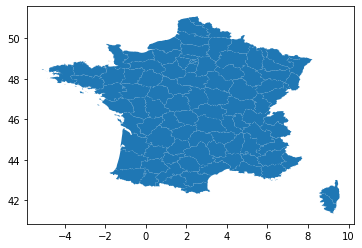

In [4]:
#formes des départements
shapefile = shapefile.iloc[:96, :] #on enlève les dom tom
shapefile['geometry'].plot()

In [5]:
shapefile.sample(5) #il y a des ploygones et des multiploygones

,code_insee,nom,nuts3,wikipedia,geometry
36,36,Indre,FR243,b'fr:Indre (d\xe9partement)',"POLYGON ((2.088723801582908 46.4103024124311, ..."
45,45,Loiret,FR246,b'fr:Loiret (d\xe9partement)',"POLYGON ((2.669342429456703 47.48477200348614,..."
22,24,Dordogne,FR611,b'fr:Dordogne (d\xe9partement)',POLYGON ((0.09536056915417936 44.8329761901651...
48,48,b'Loz\xe8re',FR814,b'fr:Loz\xe8re (d\xe9partement)',"POLYGON ((3.226811202964152 44.19026450808981,..."
70,70,b'Haute-Sa\xf4ne',FR433,b'fr:Haute-Sa\xf4ne',"POLYGON ((6.172540002684947 47.39770776480312,..."


In [6]:
#### Enrichissement des données ###

#on prepare le dataset de l'insee 
insee[['X','Y']] = insee['Geometry X Y'].str.split(',',expand=True)
insee['X']  = insee['X'].astype(float)
insee['Y']  = insee['Y'].astype(float)

#calcul d'un centroid du département grâce aux communes du groupe de communes dans le deptartement:
insee_dpt = insee.groupby(['Code Dept']).agg(
    { 'X' : np.mean, 'Y' : np.mean,  'Population' : np.sum }).reset_index()
insee_com = insee.groupby(['CODE POSTAL']).agg( 
    { 'X' : np.mean, 'Y' : np.mean,  'Population' : np.sum }).reset_index()
insee_com['CODE POSTAL'] = insee_com['CODE POSTAL'].astype('str')

#### Le fichier de l'INSEE a une grannularité fine (commune ou code insee) #### 
insee.head(2)

,CODE INSEE,NOM DE LA COMMUNE,CODE POSTAL,LIBELLE D'ACHEMINEMENT,Y Centroid,Nom Region,Nom Dept,STATUT,Code Region,Code Commune,Z Moyen,Code Dept,X Centroid,Geometry X Y,Geometry,Id Geofla,X Chef Lieu,Code Canton,Superficie,Population,Nom Commune,Code Arrondissement,Y Chef Lieu,X,Y
0,01348,ST DIDIER SUR CHALARONNE,1140,ST DIDIER SUR CHALARONNE,65665.0,RHONE-ALPES,AIN,Commune simple,82.0,348.0,182.0,01,8400.0,"46.1840408682, 4.81645666174","{""type"": ""Polygon"", ""coordinates"": [[[4.802549...",5184.0,8402.0,32.0,2513.0,2.7,SAINT-DIDIER-SUR-CHALARONNE,2.0,65658.0,46.184,4.816
1,02192,CHOUY,2210,CHOUY,69019.0,PICARDIE,AISNE,Commune simple,22.0,192.0,141.0,02,7180.0,"49.2167334121, 3.24708004453","{""type"": ""Polygon"", ""coordinates"": [[[3.240320...",671.0,7180.0,22.0,2036.0,0.4,CHOUY,1.0,69007.0,49.217,3.247


In [7]:
####préparation des données métier ####

### on supprime  les colonnes avec trop de valeurs manquantes #####
df = df.dropna(axis='columns', thresh=5000)

#### on ne garde que années de naissance réalistes ####
min_max_years = [1929, 2000]
df = df.loc[df['An_Naissance'] > min_max_years[0],:]
df = df.loc[df['An_Naissance'] < min_max_years[1],:]

##### Civilité : on ne garde que 2 sexes (pas de mlle) ####
df['Civilite'] = np.where(df['Civilite'] == 'Mlle', 'Mme' , df['Civilite'])

#### on ne considère que les colonnes exploitables assez facilement , en particulier pas de "class imbalance"####
balanced_columns = ['Civilite', 'An_Naissance', 'dpt', 'CodePostal', 'Pays_CD01_Actifs2', 
                    'Langue','DateDebut_CD01_Actifs2', 'DateDebut_CD02_Souscriptions', 
                    'FrequenceAbo', 'Pays_CD02_Souscriptions', 'NbMoisCircules', 'Prix', 
                    'frais', 'Service','Date','Campagne_Corr',  'Id-offre']
df = df[balanced_columns]

####on nettoie les département ######
df['dpt'] = df['dpt'].astype('object')
df = df.loc[df['dpt'] != 'L-', :]


#### on formate les prix ######
df['Prix'] = df['Prix'].replace(',', '.' , regex=True)
df ['Prix'] = pd.to_numeric(df['Prix'], errors='coerce')
df['Prix'] = df['Prix'].astype(float)

df['frais'] = df['frais'].replace(',', '.' , regex=True)
df ['frais'] = pd.to_numeric(df['frais'], errors='coerce')
df['frais'] = df['frais'].astype(float)

df = df.dropna(subset=['Prix'])
df = df.dropna(subset=['frais'])


In [8]:
df.head()

,Civilite,An_Naissance,dpt,CodePostal,Pays_CD01_Actifs2,Langue,DateDebut_CD01_Actifs2,DateDebut_CD02_Souscriptions,FrequenceAbo,Pays_CD02_Souscriptions,NbMoisCircules,Prix,frais,Service,Date,Campagne_Corr,Id-offre
507,M.,1955,30,3001,BELGIQUE,Hollandais,2016-06-10 02:56:15,2016-06-10 02:56:15,Mensuel,Belgium,2.0,109.3,3.4,ETUDES_NEWSLETTER,NaT,NaN,ERP-100
508,M.,1973,47,47239,ALLEMAGNE,Allemand,2016-06-10 07:41:28,2016-06-10 07:41:28,Mensuel,Germany,2.0,195.2,3.4,CIRCULER_MALIN_NEWSLETTER,NaT,NaN,ERP-100
509,M.,1950,42,42389,ALLEMAGNE,Allemand,2016-06-09 21:33:30,2016-06-09 21:33:30,Mensuel,Germany,2.0,348.2,3.4,AVANTAGES_ABONNES_NEWSLETTER,NaT,NaN,ERP-100
510,M.,1968,90,9040,BELGIQUE,Hollandais,2016-06-08 11:39:51,2016-06-08 11:39:51,Mensuel,Belgium,1.0,155.1,1.7,AVANTAGES_ABONNES_NEWSLETTER,2016-06-08 11:39:51,CAMP126,ERP-100
511,M.,1963,28,28844,ALLEMAGNE,Allemand,2016-06-09 10:10:08,2016-06-09 10:10:08,Mensuel,Germany,1.0,118.2,1.7,ETUDES_NEWSLETTER,NaT,NaN,ERP-100


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12642 entries, 507 to 13276
Data columns (total 17 columns):
Civilite                        12642 non-null object
An_Naissance                    12642 non-null int64
dpt                             12642 non-null object
CodePostal                      12642 non-null object
Pays_CD01_Actifs2               12642 non-null object
Langue                          12642 non-null object
DateDebut_CD01_Actifs2          12642 non-null datetime64[ns]
DateDebut_CD02_Souscriptions    12640 non-null datetime64[ns]
FrequenceAbo                    12642 non-null object
Pays_CD02_Souscriptions         12640 non-null object
NbMoisCircules                  12642 non-null float64
Prix                            12642 non-null float64
frais                           12642 non-null float64
Service                         12642 non-null object
Date                            4465 non-null datetime64[ns]
Campagne_Corr                   4465 non-null object
I

In [10]:
#### Enrichissement des comunes ###

### on se concentre sur  la France ####
df_fr = df.loc[df['Pays_CD01_Actifs2'] == 'FRANCE',: ]
df_fr = df_fr.sort_values(by = ['dpt', 'CodePostal'])

#regroupement par commune (on utilise le colonne 'langue' pour compter les lignes)
df_cmu = df_fr.groupby(
    ['CodePostal']).agg( {  'NbMoisCircules' : np.mean, 'Langue' : np.count_nonzero  }).reset_index()
df_cmu['NbMoisCircules']  = df_cmu['NbMoisCircules'].round(decimals = 1)
df_cmu = df_cmu.rename(columns={"Langue": "abonnes"})
df_cmu = df_cmu.sort_values(by = 'abonnes')

In [11]:
df_cmu.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2908 entries, 1453 to 1140
Data columns (total 3 columns):
CodePostal        2908 non-null object
NbMoisCircules    2908 non-null float64
abonnes           2908 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 90.9+ KB


In [12]:

#on fusionne le dataset avec celui de l'insee par code postal
df_cmu = df_cmu.merge(
    insee_com, left_on ='CodePostal', right_on = 'CODE POSTAL' , how = 'left')
df_cmu = df_cmu.dropna()

#on cree notre indicateur de 'couverture' des abonnements par comune
df_cmu['couverture'] = df_cmu['abonnes']*1000/ df_cmu['Population']
df_cmu['couverture'] = df_cmu['couverture'].astype('int')

#####Départements ####

#regroupement par dept (on utilise la colonne 'langue' pour compter les lignes)
df_dept = df_fr.groupby(
    ['dpt']).agg( {  'NbMoisCircules' : np.mean, 'Langue' : np.count_nonzero  }).reset_index()
df_dept['NbMoisCircules']  = df_dept['NbMoisCircules'].round(decimals = 1)
df_dept = df_dept.rename(columns={"Langue": "abonnes"})


####### Intégration de la géométrie ###

###on enrichit les données des formes géo des dept ##
right_join = 'code_insee'
df_dept = df_dept.merge(shapefile, left_on = 'dpt', right_on = right_join , how = 'inner')

###on enrichit les données des données insee  ##
df_dept = df_dept.merge(insee_dpt, left_on = 'dpt', right_on = 'Code Dept', how = 'left')

## on crée notre indicateur par dept
df_dept = df_dept[
    ['dpt', 'NbMoisCircules', 'abonnes', 'nom',  'Population', 'X', 'Y', 'geometry']]

df_dept['abo_vs_pop'] = 1000 * df_dept['abonnes'] / df_dept['Population']
df_dept = df_dept[[
    'dpt',   'nom', 'abonnes',  'Population','abo_vs_pop', 
    'NbMoisCircules','X', 'Y', 'geometry']]
df_dept = df_dept.sort_values(by = 'abo_vs_pop')

In [13]:
#on obtient des infos sur les abonnés par code postal
df_cmu.tail()

,CodePostal,NbMoisCircules,abonnes,CODE POSTAL,X,Y,Population,couverture
2903,75017,8.7,26,75017,48.887,2.307,168.5,154
2904,75015,6.8,28,75015,48.840,2.294,236.5,118
2905,60000,7.4,31,60000,49.422,2.071,61.3,505
2906,59400,7.2,39,59400,50.150,3.201,38.3,1018
2907,51100,7.0,99,51100,49.251,4.040,180.8,547


In [14]:
#on obtient des infos sur les abonnés par département
df_dept.tail()

,dpt,nom,abonnes,Population,abo_vs_pop,NbMoisCircules,X,Y,geometry
78,80,Somme,246,838.5,293.381,7.9,49.939,2.314,"(POLYGON ((1.651227998710059 50.1881520017981,..."
60,62,Pas-de-Calais,563,1462.0,385.089,6.7,50.460,2.336,"POLYGON ((2.177352934987066 50.20779598945769,..."
1,02,Aisne,222,541.4,410.048,7.3,49.549,3.532,"POLYGON ((3.481745983906527 48.86640497465348,..."
49,51,Marne,320,567.3,564.075,7.2,48.963,4.191,"POLYGON ((4.724894232374456 48.54129580377701,..."
58,60,Oise,484,802.9,602.815,8.4,49.428,2.415,(POLYGON ((3.042453370802382 49.22848288743595...


In [15]:
type(df_dept['geometry'][0])

shapely.geometry.polygon.Polygon

In [16]:
#### on transforme les données pour préparer la visualisation par dept

#https://github.com/geopandas/geopandas/issues/834
from shapely import geometry
upcast_dispatch = {geometry.Point: geometry.MultiPoint, 
                   geometry.LineString: geometry.MultiLineString, 
                   geometry.Polygon: geometry.MultiPolygon}

def maybe_cast_to_multigeometry(geom):
    caster = upcast_dispatch.get(type(geom), lambda x: x[0])
    return caster([geom])

#c'est ce qui permettrait de définir le type de géométrie(?)
gdf_dept = gpd.GeoDataFrame(df_dept)

In [17]:
df_dept['geometry'][1:10]

42    (POLYGON ((-2.343992935474033 47.2230789854134...
88    POLYGON ((7.096913077577037 47.49517880645919,...
27    (POLYGON ((-3.980718711900324 47.7040767907122...
85    POLYGON ((0.859690601511291 45.61326541311564,...
34    POLYGON ((2.088723801582908 46.4103024124311, ...
41    POLYGON ((3.442074494497712 44.85406601011364,...
70    POLYGON ((0.8165678746124175 47.89180518123359...
35    POLYGON ((0.4449139108260515 46.94125469923182...
29    POLYGON ((1.493073394565357 43.23725621629266,...
Name: geometry, dtype: geometry

In [18]:
#on va tout convertir en mutlipolygone
gdf_dept['geometry'] = gdf_dept['geometry'].apply(maybe_cast_to_multigeometry)

#le geojson sera nécessaire  pour la visualisation
#gdf_dept[['dpt', 'abo_vs_pop','geometry']].to_file(output_interim, driver='GeoJSON')

gdf_dept.tail()

,dpt,nom,abonnes,Population,abo_vs_pop,NbMoisCircules,X,Y,geometry
78,80,Somme,246,838.5,293.381,7.9,49.939,2.314,"(POLYGON ((1.651227998710059 50.1881520017981,..."
60,62,Pas-de-Calais,563,1462.0,385.089,6.7,50.460,2.336,(POLYGON ((2.177352934987066 50.20779598945769...
1,02,Aisne,222,541.4,410.048,7.3,49.549,3.532,(POLYGON ((3.481745983906527 48.86640497465348...
49,51,Marne,320,567.3,564.075,7.2,48.963,4.191,(POLYGON ((4.724894232374456 48.54129580377701...
58,60,Oise,484,802.9,602.815,8.4,49.428,2.415,(POLYGON ((3.042453370802382 49.22848288743595...


# Visualisation

 nombre de communes avec plus de 7 abonnés : 2691


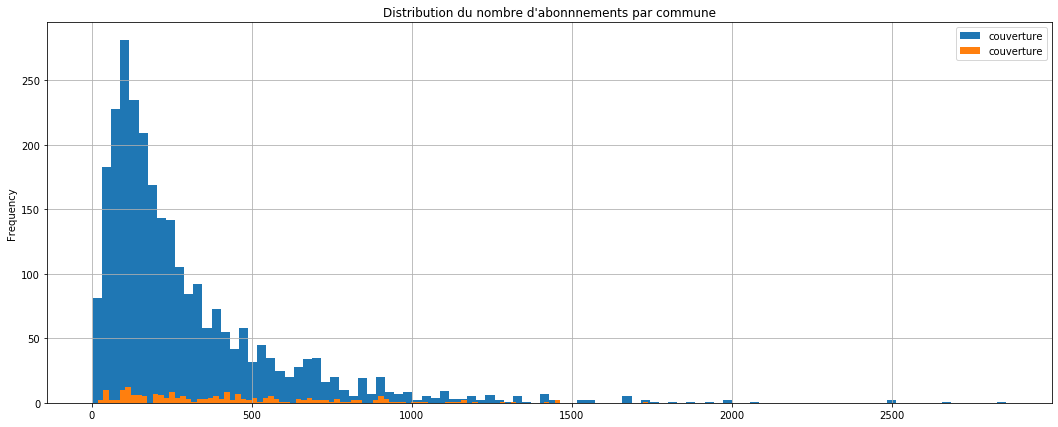

In [19]:
df_cmu['couverture'].plot(kind='hist' ,bins = 100, figsize = (18, 7), 
                          title = 'Distribution du nombre d\'abonnnements par commune',
                           ax=None, subplots=False, sharex=None, sharey=False, 
                          layout=None, use_index=True, 
                          grid=True, legend=True, style=None, logx=False, 
                          logy=False, loglog=False, xticks=None, yticks=None, 
                          xlim=None, ylim=None, rot=None, fontsize=None, 
                          colormap=None, table=False , sort_columns=False)

#on ne selectionne que les communes avec un minimum d'abonnés
minimum =  7
df_cmu2 = df_cmu.loc[df_cmu['abonnes'] > minimum,:]
print(f" nombre de communes avec plus de {minimum} abonnés : {len(df_cmu)}")


df_cmu2['couverture'].plot(kind='hist' ,bins = 100, figsize = (18, 7), 
                          title = 'Distribution du nombre d\'abonnnements par commune',
                           ax=None, subplots=False, sharex=None, sharey=False, 
                          layout=None, use_index=True, 
                          grid=True, legend=True, style=None, logx=False, 
                          logy=False, loglog=False, xticks=None, yticks=None, 
                          xlim=None, ylim=None, rot=None, fontsize=None, 
                          colormap=None, table=False , sort_columns=False)

In [20]:
#on ne selectionne que les communes avec un minimum d'abonnés
minimum =  7
df_cmu = df_cmu.loc[df_cmu['abonnes'] > minimum,:]
print(f" nombre de communes avec plus de {minimum} abonnés : {len(df_cmu)}")


#on cree la colonne pour les icônes
threshold = 500
threshold2 = 1000

df_cmu['people'] = 'small'
df_cmu['people'] = np.where(df_cmu['couverture'] > threshold, 'medium', df_cmu['people'])
df_cmu['people'] = np.where(df_cmu['couverture'] > threshold2, 'large', df_cmu['people'])

#on crée les listes
for it in df_cmu['people'].unique():

    feature_group = folium.FeatureGroup(name = f'clients {str(it)}')
    
    df_mini = df_cmu.loc[df_cmu['people'] == str(it),: ]
    location_list = df_mini[['X', 'Y']].values.tolist()
    icon_list = df_mini['people'].tolist()
    popup_cp_list = df_mini['CODE POSTAL'].values.tolist()
    popup_couverture_list = df_mini['couverture'].values.tolist()

 nombre de communes avec plus de 7 abonnés : 205


In [21]:
df_cmu.groupby('people').agg(np.mean)

,NbMoisCircules,abonnes,X,Y,Population,couverture
people,,,,,,
large,7.413,15.800,49.720,3.255,13.460,1242.933
medium,7.438,12.800,49.572,3.288,19.011,720.291
small,6.926,11.741,48.922,2.826,80.270,241.178


In [22]:
df_maxi = df_cmu.loc[df_cmu['people'] == 'large',: ]
df_maxi.head()

,CodePostal,NbMoisCircules,abonnes,CODE POSTAL,X,Y,Population,couverture,people
2732,51460,8.0,8,51460,48.995,4.569,4.6,1739,large
2740,59161,6.4,8,59161,50.201,3.285,5.5,1454,large
2758,59940,4.1,9,59940,50.667,2.696,8.6,1046,large
2762,60112,8.7,9,60112,49.507,1.994,6.2,1451,large
2770,59554,6.8,9,59554,50.202,3.205,7.7,1168,large


In [23]:
IFrame_width_px = 1024
IFrame_heigth_px = 600
france =(43,10)


m = folium.Map(location=france, zoom_start=5, control_scale=True)

folium.Choropleth(geo_data='json_dept.json', 
                  data=gdf_dept, 
                  key_on='feature.properties.dpt',
                  columns=['dpt', 'abo_vs_pop'], 
                  fill_color='RdPu',
                  legend_name='Concentration des Abonnements'
                  ).add_to(m)

##### bloc  à répéter #####

taille = 'large'

feature_group_large = folium.FeatureGroup(name = f'Présence {taille}')
    
df_maxi = df_cmu.loc[df_cmu['people'] == taille,: ]

location_list = df_maxi[['X', 'Y']].values.tolist()
icon_list = df_maxi['people'].tolist()
abonnes_list = df_maxi['abonnes'].tolist()
popup_cp_list = df_maxi['CODE POSTAL'].values.tolist()
popup_couverture_list = df_maxi['couverture'].values.tolist()
popup_circule_list = df_maxi['NbMoisCircules'].values.tolist()
    
for point in range(0, len(df_maxi)):

    #l'image doit obligatoirement être dans la boucle
    image_url = os.path.join(file_directory, img_urls[taille])
    icon = folium.features.CustomIcon(image_url,icon_size=(17, 17))

    folium.Marker(location_list[point], 
                  icon=icon,
                  popup = f"CP: {popup_cp_list[point]} Moy Mois/an : {popup_circule_list[point]}  "
                 ).add_to(feature_group_large)

feature_group_large.add_to(m)

#### fin du bloc ##
                                          
##### bloc  à répéter #####

taille = 'medium'

feature_group_medium = folium.FeatureGroup(name = f'Présence {taille}')
    
df_maxi = df_cmu.loc[df_cmu['people'] == taille,: ]

location_list = df_maxi[['X', 'Y']].values.tolist()
icon_list = df_maxi['people'].tolist()
abonnes_list = df_maxi['abonnes'].tolist()
popup_cp_list = df_maxi['CODE POSTAL'].values.tolist()
popup_couverture_list = df_maxi['couverture'].values.tolist()
popup_circule_list = df_maxi['NbMoisCircules'].values.tolist()
    
for point in range(0, len(df_maxi)):

    #l'image doit obligatoirement être dans la boucle
    image_url = os.path.join(file_directory, img_urls[taille])
    icon = folium.features.CustomIcon(image_url,icon_size=(17, 17))

    folium.Marker(location_list[point], 
                  icon=icon,
                  popup = f"CP: {popup_cp_list[point]} Moy Mois/an : {popup_circule_list[point]}  "
                 ).add_to(feature_group_medium)

feature_group_medium.add_to(m)

#### fin du bloc ##
        
legend_html =   '''
                <div style="position: fixed; 
                            top: 10px; left: 50px; width: 150px; height: 90px; 
                             z-index:9999; font-size:15px;
                            ">&nbsp;Là où nous sommes le plus représentés <br>          
                </div>
                ''' 
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl().add_to(m)    
m.save(output)


In [24]:
#nombre d'abonnements pour 1 million de personnes
from IPython.display import HTML , IFrame

IFrame(output, height=IFrame_heigth_px, width=IFrame_width_px)